In [23]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple
import pickle
from torch.utils.data import ConcatDataset, Dataset, Subset
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [24]:
train_dataset = CIFAR10('/home/vishal1/Desktop/nitin/AAMAS_Exp/CIFAR10', train=True, download=False, transform=transforms.ToTensor())
test_dataset = CIFAR10('/home/vishal1/Desktop/nitin/AAMAS_Exp/CIFAR10', train=False, download=False, transform=transforms.ToTensor())

In [25]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 25
rounds = 30
batch_size = 32
in_group_rounds=3
epochs_per_client =2
learning_rate = 2e-2
num_malicious_clients=5

In [26]:
total_train_size, total_test_size

(50000, 10000)

In [27]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()


def average_models(new_model, next, scale):
    if new_model == None:
        new_model = next
        for key in new_model:
            new_model[key] = new_model[key] * scale
    else:
        for key in new_model:
            new_model[key] = new_model[key] + (next[key] * scale)
    return new_model


In [28]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        # Update input channels to 3 for RGB images
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.fc = torch.nn.Linear(8 * 8 * 32, 10)
        # self.conv1 = torch.nn.Conv2d(3, 6, 5)
        # self.pool = torch.nn.MaxPool2d(2, 2)
        # self.conv2 = torch.nn.Conv2d(6, 16, 5)
        # self.fc1 = torch.nn.Linear(400, 120)
        # self.fc2 = torch.nn.Linear(120, 84)
        # self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        # x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        # x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        # x = x.view(-1, 16 * 5 * 5)
        # x = torch.nn.functional.relu(self.fc1(x))
        # x = torch.nn.functional.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [29]:
def partition_data_label_quantity(
    num_clients, labels_per_client, train_dataset, total_train_size, seed=42
):
    trainset = train_dataset
    prng = np.random.default_rng(seed)

    targets = trainset.targets
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    num_classes = len(set(targets))

    if labels_per_client != 2:
        raise ValueError("This function is designed to assign exactly 2 labels per client.")

    # Create specific class pairs and assign to clients
    class_pairs = [(i, i + 1) for i in range(0, num_classes, 2)]
    contains = [class_pairs[i % len(class_pairs)] for i in range(num_clients)]

    # Prepare indices for clients
    idx_clients = [[] for _ in range(num_clients)]
    for i, (class1, class2) in enumerate(contains):
        idx_class1 = np.where(targets == class1)[0]
        idx_class2 = np.where(targets == class2)[0]
        
        # Shuffle the indices
        prng.shuffle(idx_class1)
        prng.shuffle(idx_class2)
        
        # Combine indices and assign to the client
        combined_indices = np.concatenate([idx_class1, idx_class2])
        prng.shuffle(combined_indices)

        # Assign a proportional subset of combined indices to the client
        idx_clients[i] = combined_indices[: total_train_size // num_clients].tolist()

    # Create subsets for each client
    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]
    return trainsets_per_client


In [30]:
client_datasets = partition_data_label_quantity(num_clients,2,train_dataset,len(train_dataset))

FL

In [31]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()

In [32]:
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [33]:
global_net = to_device(FederatedNet(), device)
history_FL = []
traffic=[]
weights=[]
load_model=None
total_length_dataset=len(train_dataset)
for i in range(rounds):
    curr_parameters = global_net.state_dict()
    new_model=None
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size()/total_length_dataset
        new_model=average_models(new_model,client_parameters,fraction)
    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
        total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(2*num_clients)
    history_FL.append((train_acc, dev_acc,i))

After round 1, train_loss = 2.2328, dev_loss = 2.2268, dev_acc = 0.1824

After round 2, train_loss = 2.0607, dev_loss = 2.0583, dev_acc = 0.2797

After round 3, train_loss = 1.9731, dev_loss = 1.9731, dev_acc = 0.3242

After round 4, train_loss = 1.9156, dev_loss = 1.9165, dev_acc = 0.3482

After round 5, train_loss = 1.8607, dev_loss = 1.8636, dev_acc = 0.3625

After round 6, train_loss = 1.8146, dev_loss = 1.8185, dev_acc = 0.3793

After round 7, train_loss = 1.7789, dev_loss = 1.785, dev_acc = 0.389

After round 8, train_loss = 1.7458, dev_loss = 1.7527, dev_acc = 0.3992

After round 9, train_loss = 1.7176, dev_loss = 1.7256, dev_acc = 0.4079

After round 10, train_loss = 1.695, dev_loss = 1.7055, dev_acc = 0.4163

After round 11, train_loss = 1.6729, dev_loss = 1.6845, dev_acc = 0.4156

After round 12, train_loss = 1.6501, dev_loss = 1.6628, dev_acc = 0.4311

After round 13, train_loss = 1.6282, dev_loss = 1.6425, dev_acc = 0.4386

After round 14, train_loss = 1.6153, dev_loss = 1.

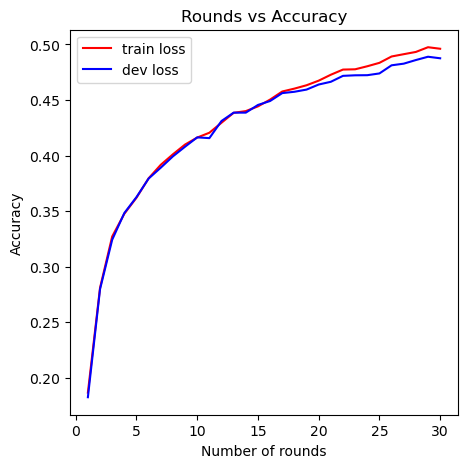

In [34]:
plt.plot([i + 1 for i in range(len(history_FL))], [history_FL[i][0] for i in range(len(history_FL))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history_FL))], [history_FL[i][1] for i in range(len(history_FL))], color='b', label='dev loss')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [35]:
print(max(history))
print(traffic[0])

NameError: name 'history' is not defined

In [ ]:
history_file_name="./fedavg_2class_fl_history"
weights_file_name="./fedavg_2class_fl_weights"
traffic_file_name="./fedavg_2class_fl_traffic"

In [ ]:
with open(history_file_name, "wb") as fp:
        pickle.dump(history, fp)
with open(weights_file_name, "wb") as fp:
        pickle.dump(weights, fp)
with open(traffic_file_name, "wb") as fp:
        pickle.dump(traffic, fp)

DFL

In [36]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model

In [37]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [38]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_DFL = []
weights=[]
traffic=[]
load_model=None
total_data_size=len(train_dataset)
for i in range(rounds):
    new_model=None
    for client in clients:
        fraction = client.get_dataset_size()/total_data_size
        if i == 0:
            client_parameters=client.train(curr_parameters)
        else:
            client_parameters = client.train(client.aggregated_parameters())
        for clt in clients:
                clt.recieve_parameters(client.get_client_id(),client_parameters,fraction)
        new_model=average_models(new_model,client_parameters,fraction)
    


    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append((num_clients)*(num_clients-1))
    history_DFL.append((train_acc, dev_acc,i))

After round 1, train_loss = 2.2226, dev_loss = 2.2215, dev_acc = 0.1787

After round 2, train_loss = 2.0231, dev_loss = 2.0233, dev_acc = 0.2822

After round 3, train_loss = 1.9476, dev_loss = 1.9536, dev_acc = 0.3101

After round 4, train_loss = 1.8689, dev_loss = 1.8794, dev_acc = 0.3328

After round 5, train_loss = 1.8161, dev_loss = 1.8277, dev_acc = 0.3489

After round 6, train_loss = 1.7831, dev_loss = 1.7974, dev_acc = 0.3618

After round 7, train_loss = 1.7498, dev_loss = 1.7643, dev_acc = 0.3792

After round 8, train_loss = 1.7227, dev_loss = 1.7383, dev_acc = 0.3904

After round 9, train_loss = 1.6888, dev_loss = 1.7057, dev_acc = 0.4067

After round 10, train_loss = 1.6639, dev_loss = 1.6822, dev_acc = 0.4212

After round 11, train_loss = 1.6363, dev_loss = 1.6567, dev_acc = 0.4306

After round 12, train_loss = 1.6134, dev_loss = 1.6339, dev_acc = 0.4393

After round 13, train_loss = 1.5815, dev_loss = 1.6031, dev_acc = 0.4541

After round 14, train_loss = 1.5599, dev_loss =

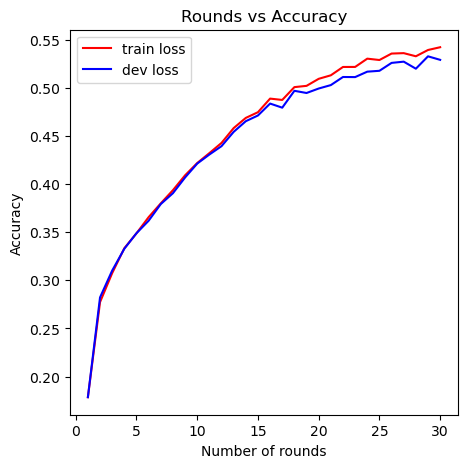

In [39]:
plt.plot([i + 1 for i in range(len(history_DFL))], [history_DFL[i][0] for i in range(len(history_DFL))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history_DFL))], [history_DFL[i][1] for i in range(len(history_DFL))], color='b', label='dev loss')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [40]:
print(max(history))
print(traffic[0])

NameError: name 'history' is not defined

In [ ]:
history_file_name="./fedavg_2class_dfl_history"
weights_file_name="./fedavg_2class_dfl_weights"
traffic_file_name="./fedavg_2class_dfl_traffic"

In [ ]:
with open(history_file_name, "wb") as fp:
        pickle.dump(history, fp)
with open(weights_file_name, "wb") as fp:
        pickle.dump(weights, fp)
with open(traffic_file_name, "wb") as fp:
        pickle.dump(traffic, fp)

HDFL

In [52]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
        self.server_id=-1
        self.distance=random.randint(1,100)
        self.client_data_server=[]
    
    def set_server_id(self,client_id):
        self.client_data_server=[]
        self.server_id=client_id
    
    def get_server_id(self):
        return self.server_id
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        # print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model
    
    def recieve_data_as_server(self,client_parameter,fraction):
        client_object={"client_parameter":client_parameter,"fraction":fraction}
        self.client_data_server.append(client_object)
    

    def aggregate_parameter_as_server(self):
         local_aggregated_model_as_server=None
         for data in self.client_data_server:
              local_aggregated_model_as_server=average_models(local_aggregated_model_as_server,data["client_parameter"],data["fraction"])
         self.client_data_server.clear()
         return local_aggregated_model_as_server   

In [53]:
def utility_function(client_set_1,client_set_2,data):
  client_set_1_average=None
  client_set_2_average=None
  for i in client_set_1:
    client_set_1_average=average_models(client_set_1_average,data[i],1)
  for i in client_set_2:
    client_set_2_average=average_models(client_set_2_average,data[i],1)
  model1_weights = []
  model2_weights = []
  for key, value in client_set_1_average.items():
      model1_weights.append(value.detach().cpu())

  for key, value in client_set_2_average.items():
      model2_weights.append(value.detach().cpu())
  weight1_flat = torch.cat([param.view(-1) for param in model1_weights])
  weight2_flat = torch.cat([param.view(-1) for param in model2_weights])
  cosine_sim = torch.nn.functional.cosine_similarity(weight1_flat, weight2_flat, dim=0)
  return cosine_sim.item()

In [54]:
def generateGroupsGame(data,num_clients):
    groups=[]
    for i in range(0,num_clients):
        groups.append([i])
    while True:
        for group in groups:
            for x in group:
                no_change_flag=0
                m_i_n_group=None
                m_i_n_utility=100
                for g in groups:
                    if g!=group:
                        if len(g) >= 1 and len(group) > 1:
                            tempset_1=g.copy()
                            tempset_1.append(x)
                            tempset_2=group.copy()
                            tempset_2.remove(x)
                            if utility_function(tempset_1,tempset_2,data) > utility_function(g,group,data): 
                                if m_i_n_utility > utility_function(tempset_1,tempset_2,data):
                                    m_i_n_group=g
                                    m_i_n_utility=utility_function(tempset_1,tempset_2,data)        
                        elif len(group)<=1:
                            if utility_function(g,group,data) < m_i_n_utility:
                                m_i_n_group=g
                                m_i_n_utility=utility_function(g,group,data)
                if m_i_n_group is not None:  
                    group.remove(x)
                    m_i_n_group.append(x)
                    no_change_flag=1
                    if len(group) <=0 :
                        groups.remove(group)
        if no_change_flag == 0:
            break
    print("end")
    return groups

In [55]:
def groupDataLength(groups,clients):
    group_dataset_length=[]
    for grp in groups:
        totalcount=0
        for clt in grp:
            totalcount+=clients[clt].get_dataset_size()
        group_dataset_length.append(totalcount)
    return group_dataset_length

In [56]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [57]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
data = []
for client in clients:
    paramerter=client.train(curr_parameters)
    data.append(paramerter)

In [58]:
# groups=generateGroupsGame(data,num_clients)
groups = [
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14],
    [15, 16, 17, 18, 19],
    [20, 21, 22, 23, 24]
]
print(groups)
group_dataset_length=groupDataLength(groups,clients)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19], [20, 21, 22, 23, 24]]


In [59]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_HDFL = []
weights=[]
traffic=[]
load_model=None
total_dataset_length=len(train_dataset)
flag=True
for i in range(rounds):
    traffic_single_sum=0
    #chosing the server client with a uniform probability
    server=[]
    for grp in groups:
        traffic_single_sum=traffic_single_sum+len(grp)-1
        server_id=np.random.choice(grp,p=np.ones(len(grp))/len(grp))
        server.append(server_id)
        clients[server_id].set_server_id(server_id)
    #in group mesh decentralized learning
    k=0
    for grp in groups:
        flag=True
        for j in range(in_group_rounds):
            traffic_single_sum=traffic_single_sum+((len(grp)-1)*len(grp))
            for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                if i == 0 and flag : #at the very start train using initial global model param
                    client_parameters=clients[clt].train(curr_parameters) 
                elif j == 0: #in subsequent rounds, use load_model at the start of in group rounds
                    client_parameters=clients[clt].train(load_model) 
                else: #In other scenarios, use aggregated models
                    client_parameters = clients[clt].train(clients[clt].aggregated_parameters())
                for clt_1 in grp: #transfer the current client's learned parameters to all clients (including itself) => to be used for aggregation in each client
                        clients[clt_1].recieve_parameters(clt_1,client_parameters,fraction)
            flag=False
        #aggregating on the random choosn server
        for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                t=clients[clt].aggregated_parameters()
                clients[server[k]].recieve_data_as_server(t,fraction)
        k+=1
    #aggregating the parameters
    aggregateds=[]
    for clt in server:
            t=clients[clt].aggregate_parameter_as_server()
            aggregateds.append(t)
    #choosing the server from the amongst server at unifrom probability
    server_id=np.random.choice(server,p=np.ones(len(server))/len(server))
    clients[server_id].set_server_id(server_id)
    traffic_single_sum=traffic_single_sum+len(server)
    #sending the data to the chosen from all the group server
    group_number=0
    for clt in aggregateds:
            fraction=group_dataset_length[group_number]/total_dataset_length
            group_number+=1
            clients[server_id].recieve_data_as_server(clt,fraction)
    #aggregating at the top level server
    traffic_single_sum=traffic_single_sum+num_clients        
    aggregated_parameters_top=clients[server_id].aggregate_parameter_as_server()
    load_model=aggregated_parameters_top.copy()
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(load_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(traffic_single_sum)
    history_HDFL.append((train_acc, dev_acc,i))

After round 1, train_loss = 2.0678, dev_loss = 2.0648, dev_acc = 0.2823

After round 2, train_loss = 1.9685, dev_loss = 1.9677, dev_acc = 0.3142

After round 3, train_loss = 1.8957, dev_loss = 1.8977, dev_acc = 0.3441

After round 4, train_loss = 1.8299, dev_loss = 1.8355, dev_acc = 0.3623

After round 5, train_loss = 1.7737, dev_loss = 1.784, dev_acc = 0.3732

After round 6, train_loss = 1.7195, dev_loss = 1.7361, dev_acc = 0.3939

After round 7, train_loss = 1.6705, dev_loss = 1.6929, dev_acc = 0.4121

After round 8, train_loss = 1.6337, dev_loss = 1.663, dev_acc = 0.4177

After round 9, train_loss = 1.5975, dev_loss = 1.6329, dev_acc = 0.428

After round 10, train_loss = 1.571, dev_loss = 1.6152, dev_acc = 0.4306

After round 11, train_loss = 1.5592, dev_loss = 1.613, dev_acc = 0.4319

After round 12, train_loss = 1.5494, dev_loss = 1.6116, dev_acc = 0.4349

After round 13, train_loss = 1.539, dev_loss = 1.6111, dev_acc = 0.4402

After round 14, train_loss = 1.5532, dev_loss = 1.637

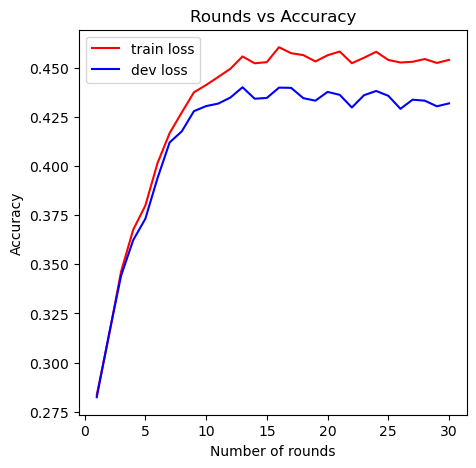

In [60]:
plt.plot([i + 1 for i in range(len(history_HDFL))], [history_HDFL[i][0] for i in range(len(history_HDFL))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history_HDFL))], [history_HDFL[i][1] for i in range(len(history_HDFL))], color='b', label='dev loss')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print(max(history))
print(traffic[0])

In [ ]:
history_file_name="./fedavg_2class_hdfl_history"
weights_file_name="./fedavg_2class_hdfl_weights"
traffic_file_name="./fedavg_2class_hdfl_traffic"

In [ ]:
with open(history_file_name, "wb") as fp:
        pickle.dump(history, fp)
with open(weights_file_name, "wb") as fp:
        pickle.dump(weights, fp)
with open(traffic_file_name, "wb") as fp:
        pickle.dump(traffic, fp)